TF version: 2.19.0
Upload gambar CONTENT (utama):


Saving lumba-lumba.jpg to lumba-lumba (1).jpg
Upload gambar STYLE (batik):


Saving batik.jpg to batik (1).jpg


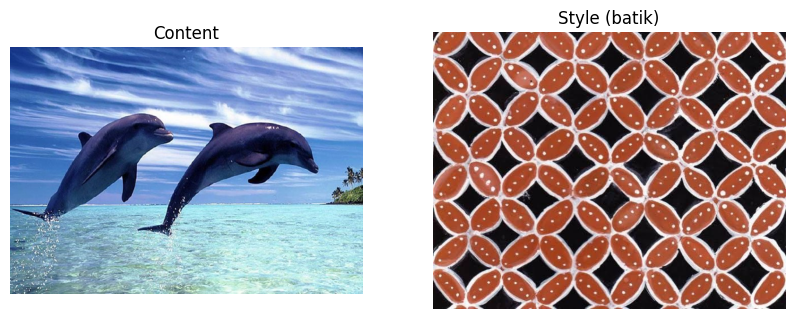

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 491, 624, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 358, 512, 3))
  warnings.warn(msg)


Step 0/350 — Total: 11446391808.0000, Style: 11438783488.0000, Content: 7608537.0000
Step 25/350 — Total: 10424872960.0000, Style: 10414560256.0000, Content: 10313018.0000
Step 50/350 — Total: 10121549824.0000, Style: 10110684160.0000, Content: 10865924.0000
Step 75/350 — Total: 9831333888.0000, Style: 9819577344.0000, Content: 11756769.0000
Step 100/350 — Total: 9549791232.0000, Style: 9536970752.0000, Content: 12820187.0000
Step 125/350 — Total: 9275445248.0000, Style: 9261472768.0000, Content: 13972860.0000
Step 150/350 — Total: 9007797248.0000, Style: 8992647168.0000, Content: 15150231.0000
Step 175/350 — Total: 8747067392.0000, Style: 8730737664.0000, Content: 16329409.0000
Step 200/350 — Total: 8492064768.0000, Style: 8474570240.0000, Content: 17494644.0000
Step 225/350 — Total: 8242122240.0000, Style: 8223500800.0000, Content: 18621352.0000
Step 250/350 — Total: 7997347328.0000, Style: 7977645568.0000, Content: 19701620.0000
Step 275/350 — Total: 7757834752.0000, Style: 77371130

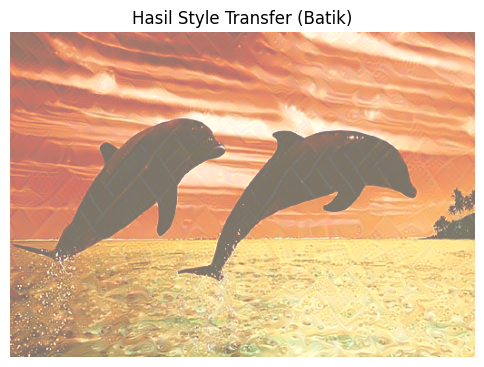

Tersimpan: hasil_style_transfer_batik.jpg


In [2]:
# Neural Style Transfer (perbaikan) — Colab ready
# Pastikan runtime: GPU (Recommended)

import tensorflow as tf
import numpy as np
from PIL import Image
import time
from tensorflow.keras.applications import vgg19
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image as kp_image
import matplotlib.pyplot as plt

print("TF version:", tf.__version__)

# --------------------------
# Helper: load / preprocess / deprocess
# --------------------------
max_dim = 512

def load_img(path, resize=True):
    img = Image.open(path).convert('RGB')
    if resize:
        long = max(img.size)
        scale = max_dim / long
        new_size = (round(img.size[0]*scale), round(img.size[1]*scale))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
    arr = np.array(img).astype(np.float32)
    arr = np.expand_dims(arr, axis=0)  # batch dim
    return arr

def preprocess_for_vgg(x):
    # x expected in range [0,255], shape (1,h,w,3)
    # If x is a tf.Variable, convert it to numpy array first -- this comment was misleading in tf.function context
    # vgg19.preprocess_input can handle tf.Tensor directly, no need for .numpy() inside tf.function
    x_proc = vgg19.preprocess_input(x)  # converts RGB->BGR and subtracts mean
    return x_proc

def deprocess_img(x):
    # x is numpy array with batch possibly; returns uint8 image HxWx3
    x = x.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    # VGG preprocess subtracts [103.939, 116.779, 123.68]
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]  # BGR -> RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def imshow_batch(x, title=None):
    im = deprocess_img(x)
    plt.imshow(im)
    if title: plt.title(title)
    plt.axis('off')

# --------------------------
# Upload/define your images
# --------------------------
# Jika di Colab: gunakan files.upload(); di sini contoh menggunakan get_file placeholders
from google.colab import files
print("Upload gambar CONTENT (utama):")
uploaded = files.upload()
content_path = list(uploaded.keys())[0]

print("Upload gambar STYLE (batik):")
uploaded = files.upload()
style_path = list(uploaded.keys())[0]

# Load images
content_raw = load_img(content_path, resize=True)        # kita resize content untuk cepat
style_raw   = load_img(style_path, resize=False)         # jangan resize style biar detail terjaga

# Show previews
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Content"); plt.imshow(np.squeeze(content_raw).astype('uint8')); plt.axis('off')
plt.subplot(1,2,2); plt.title("Style (batik)"); plt.imshow(np.squeeze(style_raw).astype('uint8')); plt.axis('off')
plt.show()

# --------------------------
# Build VGG model to extract features
# --------------------------
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1','block2_conv1','block3_conv1',
    'block4_conv1','block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# load VGG19
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
feature_extractor = models.Model([vgg.input], outputs)

# --------------------------
# gram matrix (correct)
# --------------------------
def gram_matrix(tensor):
    # tensor shape: (batch, h, w, channels)
    x = tensor
    batch, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
    x = tf.reshape(x, (batch, -1, c))  # (batch, h*w, c)
    gram = tf.matmul(x, x, transpose_a=True)  # (batch, c, c)
    num_locations = tf.cast(h*w, tf.float32)
    return gram / num_locations

# --------------------------
# get feature representations (targets)
# --------------------------
def get_feature_representations(model, content, style):
    # Preprocessing for content and style images (raw numpy arrays here)
    content_pre = preprocess_for_vgg(content)
    style_pre = preprocess_for_vgg(style)

    outputs_style_content = model(style_pre)
    outputs_content = model(content_pre)

    # outputs are list: first num_style_layers are style, then content
    style_features = [outputs_style_content[i] for i in range(num_style_layers)]
    content_features = [outputs_content[num_style_layers + i] for i in range(num_content_layers)]

    gram_style_features = [gram_matrix(feat) for feat in style_features]
    return gram_style_features, content_features

gram_style_targets, content_targets = get_feature_representations(feature_extractor, content_raw, style_raw)

# --------------------------
# loss functions
# --------------------------
style_weight = 1e-1   # tingkatkan agar motif batik lebih kuat
content_weight = 1e4

def compute_loss(model, init_image):
    # init_image is a tf.Variable, preprocess_for_vgg needs to handle it as a tensor
    init_pre = preprocess_for_vgg(init_image)
    outputs = model(init_pre)
    style_outputs = outputs[:num_style_layers]
    content_outputs = outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_gram, comb_feat in zip(gram_style_targets, style_outputs):
        gram_comb = gram_matrix(comb_feat)
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_comb - target_gram))

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_targets, content_outputs):
        # both have batch dim, so index [0] to compare (or remove batch)
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content[0] - target_content[0]))

    style_score *= style_weight
    content_score *= content_weight
    total_loss = style_score + content_score
    return total_loss, style_score, content_score

# --------------------------
# optimization loop
# --------------------------
init_image = tf.Variable(content_raw, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=0.02)

@tf.function()
def train_step():
    with tf.GradientTape() as tape:
        loss, s_loss, c_loss = compute_loss(feature_extractor, init_image)
    grad = tape.gradient(loss, init_image)
    optimizer.apply_gradients([(grad, init_image)])
    # clip pixel values to reasonable range (we keep values in [0,255])
    init_image.assign(tf.clip_by_value(init_image, 0.0, 255.0))
    return loss, s_loss, c_loss

# Run
iterations = 350  # naikkan jika mau hasil lebih halus/sempurna
start = time.time()
best_loss = float('inf')
best_img = None

for i in range(iterations):
    loss, s_loss, c_loss = train_step()
    if loss < best_loss:
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())
    if i % 25 == 0:
        print(f"Step {i}/{iterations} — Total: {loss.numpy():.4f}, Style: {s_loss.numpy():.4f}, Content: {c_loss.numpy():.4f}")

end = time.time()
print("Waktu total:", end - start)

# --------------------------
# show & save result
# --------------------------
plt.figure(figsize=(6,6))
plt.imshow(best_img)
plt.axis('off')
plt.title("Hasil Style Transfer (Batik)")
plt.show()

Image.fromarray(best_img).save('hasil_style_transfer_batik.jpg')
print("Tersimpan: hasil_style_transfer_batik.jpg")